# Continued exploration of models designed for the range dataset.

Further experimentation on creating a model for the range data based off of the results from "10_range_data_model_initial_testing.ipynb"

The first experiment looks at only using one range cell as input to the models deemed successful from "10_range_data_model_initial_testing.ipynb".

## Notebook setup

In [1]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
    
DATA_PATH_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_applied/' # not used
DATA_PATH_NO_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_not_applied/'

RESULTS_PATH = BASE_PATH + 'results/range_data_model_further_experimentation/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
MODEL_PATH = BASE_PATH + 'models/range_data_model_further_experimentation/'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [3]:
from keras import backend as K 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.callbacks import CSVLogger
from keras.utils import Sequence, to_categorical
from keras.layers import Input, Conv1D, Multiply, Add, Activation, AveragePooling1D, Flatten, Dense
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint
import sys

Using TensorFlow backend.


In [4]:
OVERWRITE_RESULTS = False
OVERWRITE_GRAPHS = True

## Data Setup

In [5]:
# Load in data dictionary.
# This does not load in any actual data,
# just the dictionary with the names of the files and their associated labels
with open(DATA_PATH_NO_MTI + "index.pkl", "rb") as file:
    data = pickle.load(file)

In [6]:
# Remove user C as this user is reserved for the test set
try:
    del data["C"]
except KeyError:
    print ("Key 'C' not found")

In [7]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [8]:
labels = {}
partition = {'train': [], 'validation': []}  # contains list of training and validation ID's
validation_user = "B"  # use user B for validation

for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            for row in result:
                if user_letter == validation_user:
                    partition["validation"].append(row)
                    labels[row] = convert_label_to_int(action)

                else:
                    partition["train"].append(row)
                    labels[row] = convert_label_to_int(action)

In [5]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

## DataGenerator

In [10]:
'''Based on code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly'''

class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self, list_IDs, labels, batch_size=32, dim=(3000),
                 n_classes=7, shuffle=False, data_directory='data/',
                 bin_range=(0,60), take_average=False, every_second_cell=False):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_directory = data_directory
        self.bin_range=bin_range
        self.take_average = take_average
        self.every_second_cell = every_second_cell
        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.take_average:
                X[i,] = abs(np.average(np.load(self.data_directory + ID), axis=1)[:,np.newaxis])
                
            elif self.every_second_cell:
                X[i,] = abs(np.load(self.data_directory + ID))[:,::2]
                
            else:
                X[i,] = abs(np.load(self.data_directory + ID))[:,self.bin_range[0]:self.bin_range[1]]
                
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

## Function to aid the exploration of models.

In [9]:
def test_model(model, training_generator, validation_generator,
               epochs, csvlog_path, verbose=True, load_weights=False, weights_path=''):
    # Generators

    
    weights_path = MODEL_PATH + weights_path

    start_epoch = 0
    if load_weights:
        model = load_model(weights_path)
        last_epoch = weights_path.split("-")[-3]
        start_epoch = int(last_epoch)
        
    model_path = csvlog_path.split(".")[-2] # remove the .csv
    if not load_weights:
        model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    checkpoint = ModelCheckpoint(MODEL_PATH + model_path + "_epoch-{epoch:02d}-{val_acc:.2f}.hdf5",
                                 monitor='val_acc', verbose=0, save_best_only=False,
                                 save_weights_only=False, mode='auto', period=1)

    csv_logger = CSVLogger(RESULTS_PATH + csvlog_path, append=True)
    callbacks_list = [checkpoint, csv_logger]
    # Train model on dataset
    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        use_multiprocessing=False,
                        workers=1,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        initial_epoch=start_epoch,
                        verbose=verbose)

### Visualize Results

In [12]:
def visualize_results(csvlog_path, save=False, save_file_name=""):
    df = pd.read_csv(RESULTS_PATH + csvlog_path)
    epoch = df['epoch'] +1
    train = df["acc"] * 100 # convert to %
    val = df['val_acc'] * 100 # convert to %
    plt.figure()
    plt.plot(epoch, train, 'b--', marker='x', label='Training (Subjects A, D, E and F)')
    plt.plot(epoch, val, 'r-', marker='x', label='Validation (Subject B)')
    plt.xticks(epoch)
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Accuracy (%)')
    plt.grid()
    if save:
        plt.savefig(RESULTS_PATH + save_file_name, format='pdf')
    plt.show()

## Model 1: Wavenet model adapted based on interpretation from Wavenet Paper

Keras implementation of wavenet model taken from https://github.com/basveeling/wavenet and https://github.com/mjpyeon/wavenet-classifier

This model has then been adapted to the classification task based on the intrustions from the paper "WAVENET: A GENERATIVE MODEL FOR RAW AUDIO" (https://arxiv.org/pdf/1609.03499.pdf)

Specifically:
"For this task we added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160× downsampling).  The pooling layer was followed by a few non-causal convolutions."

In [13]:
class WaveNetClassifier:
    def __init__(self, input_shape, output_shape, kernel_size=2, dilation_depth=9, nb_stacks=1, nb_filters=40,
                 pool_size_1=80, pool_size_2=100, use_skip_connections=True):

        self.activation = 'softmax'
        self.pool_size_1 = pool_size_1
        self.pool_size_2 = pool_size_2
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.dilation_depth = dilation_depth
        self.nb_filters = nb_filters
        self.use_skip_connections = use_skip_connections
        self.input_shape = input_shape
        self.output_shape = output_shape

        if len(input_shape) == 1:
            self.expand_dims = True
        elif len(input_shape) == 2:
            self.expand_dims = False
        else:
            print('ERROR: wrong input shape')
            sys.exit()

        self.model = self.build_model()

    def residual_block(self, x, i, stack_nb):
        original_x = x
        tanh_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding='causal',
                          name='dilated_conv_%d_tanh_s%d' % (2 ** i, stack_nb), activation='tanh')(x)
        sigm_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding='causal',
                          name='dilated_conv_%d_sigm_s%d' % (2 ** i, stack_nb), activation='sigmoid')(x)
        x = Multiply(name='gated_activation_%d_s%d' % (i, stack_nb))([tanh_out, sigm_out])

        res_x = Conv1D(self.nb_filters, 1, padding='same')(x)
        skip_x = Conv1D(self.nb_filters, 1, padding='same')(x)
        res_x = Add()([original_x, res_x])
        return res_x, skip_x

    def build_model(self):
        input_layer = Input(shape=self.input_shape, name='input_part')
        out = input_layer
        skip_connections = []
        out = Conv1D(self.nb_filters, self.kernel_size,
                     dilation_rate=1,
                     padding='causal',
                     name='initial_causal_conv'
                     )(out)
        for stack_nb in range(self.nb_stacks):
            for i in range(0, self.dilation_depth + 1):
                out, skip_out = self.residual_block(out, i, stack_nb)
                skip_connections.append(skip_out)

        if self.use_skip_connections:
            out = Add()(skip_connections)
        out = Activation('relu')(out)
        # added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames
        # spanning 10 milliseconds (160× downsampling)
        # mean pooling layer adjust pool_size_1 to change downsampling
        out = AveragePooling1D(self.pool_size_1, padding='same', name='mean_pooling_layer_downsampling')(out)

        # few non-causal convolutions
        '''
        *Update 15/02/2019*
        I have now realized that self.pool_size_1 and self.pool_size_2 actually represent kernel size here.
        Due to the length of time this notebook takes to run and as the values set worked this will not be rerun
        but has been updated in notebook 14 conducting the hyperparameter search.
        '''
        out = Conv1D(self.nb_filters, self.pool_size_1, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.nb_filters, self.pool_size_2, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.output_shape, self.pool_size_2, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.output_shape, self.pool_size_2, strides=2, padding='same', activation='relu')(out)


        out = Flatten()(out)
        out = Dense(512, activation='relu')(out)
        out = Dense(self.output_shape, activation='softmax')(out)

        return Model(input_layer, out)

    def get_model(self):
        return self.model

    def get_summary(self):
        self.model.summary()

    def get_receptive_field(self):
        k = self.kernel_size
        n = self.dilation_depth
        s = self.nb_stacks
        r_s = k + (2*(k-1)*((2**(n-1))-1))  # receptive field for one stack
        return (s*r_s) - (s-1)  # total receptive field for 's' number of stacks


## Fixed Parameters

In [14]:
# Try all bins to start with
bin_range = (0, 63)
data_shape = (3000, 63)
n_filters = 64
activation = 'softmax'
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 16
epochs = 5
dilation_depth = 8
nb_stacks = 3

## Average of all range cells

In [15]:
data_shape = (3000, 1)

wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

wnc.build_model()
model = wnc.get_model()

# Parameters
params = {'dim': data_shape,
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'data_directory': DATA_PATH_NO_MTI,
          'bin_range': bin_range,
          'take_average': True}
training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)

csvlog_path = "average_of_all_range_cells.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

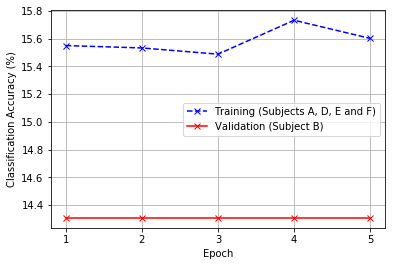

In [16]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

In [17]:
K.clear_session()

## One range cell

### Cell 0

In [18]:
data_shape = (3000, 1)
bin_range = (0, 1)

wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

wnc.build_model()
model = wnc.get_model()

params = {'dim': data_shape,
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'data_directory': DATA_PATH_NO_MTI,
          'bin_range': bin_range}
training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)

csvlog_path = "one_range_cell_0.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

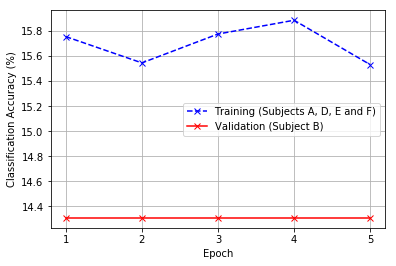

In [19]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

In [34]:
K.clear_session()

### Cell 30

In [20]:
data_shape = (3000, 1)
bin_range = (30, 31)

wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

wnc.build_model()
model = wnc.get_model()

params = {'dim': data_shape,
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'data_directory': DATA_PATH_NO_MTI,
          'bin_range': bin_range}
training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)
csvlog_path = "one_range_cell_30.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

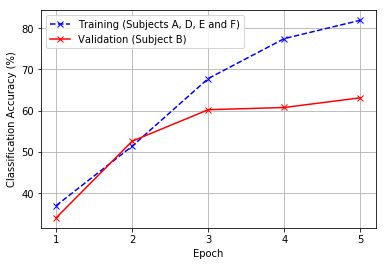

In [21]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

In [ ]:
K.clear_session()

### Cell 62

In [22]:
data_shape = (3000, 1)
bin_range = (62, 63)

wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

wnc.build_model()
model = wnc.get_model()

params = {'dim': data_shape,
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'data_directory': DATA_PATH_NO_MTI,
          'bin_range': bin_range}
training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)
csvlog_path = "one_range_cell_62.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

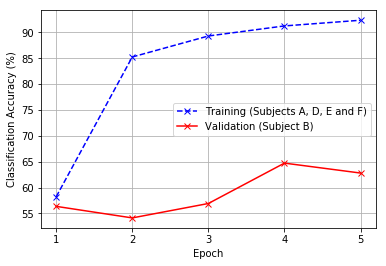

In [23]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

In [ ]:
K.clear_session()

## Every Second range cell

In [24]:
data_shape = (3000, 32)

wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

wnc.build_model()
model = wnc.get_model()

# Parameters
params = {'dim': data_shape,
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'data_directory': DATA_PATH_NO_MTI,
          'bin_range': bin_range,
          'every_second_cell': True}
training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)
csvlog_path = "every_second_range_cell.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

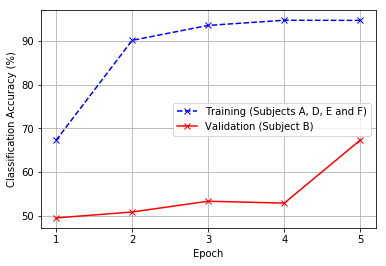

In [25]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

In [ ]:
K.clear_session()

Taking every second range cell appears to perform better than all range cells (see notebook 10)

# Combined Graphs

In [34]:
all_cells = pd.read_csv(BASE_PATH + "results/range_data_model_initial_testing/model_1_NO_MTI_dd_8_stacks_3.csv")
average = pd.read_csv(RESULTS_PATH + "average_of_all_range_cells.csv")
cell_0 = pd.read_csv(RESULTS_PATH + "one_range_cell_0.csv")
cell_30 = pd.read_csv(RESULTS_PATH + "one_range_cell_30.csv")
cell_62 = pd.read_csv(RESULTS_PATH + "one_range_cell_62.csv")
every_second = pd.read_csv(RESULTS_PATH + "every_second_range_cell.csv")


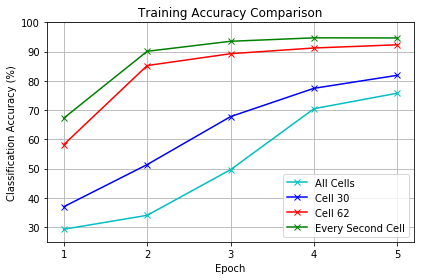

In [39]:
epochs = average['epoch'] + 1
plt.plot(epochs, all_cells['acc'] * 100, 'c', label="All Cells", marker='x')
plt.plot(epochs, cell_30['acc'] * 100, 'b', label="Cell 30", marker='x')
plt.plot(epochs, cell_62['acc'] * 100, 'r', label="Cell 62", marker='x')
plt.plot(epochs, every_second['acc'] * 100, 'g', label="Every Second Cell", marker='x')
# plt.plot(epochs, cell_30['val_acc'] * 100, 'b', label="Cell 30", marker='x')
# plt.plot(epochs, cell_62['val_acc'] * 100, 'r', label="Cell 62", marker='x')
# plt.plot(epochs, every_second['val_acc'] * 100, 'g', label="Every second cell", marker='x')
plt.xticks(epochs)
plt.ylim((25, 100))

plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")
plt.title("Training Accuracy Comparison")

plt.grid(True)
plt.legend()

plt.tight_layout()
if OVERWRITE_GRAPHS:
    plt.savefig(RESULTS_PATH + 'train_acc.pdf', format='pdf')

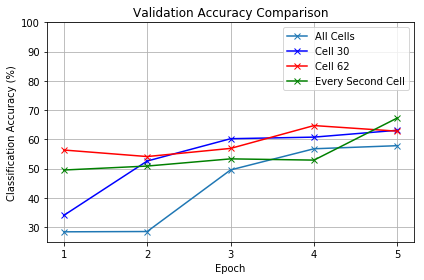

In [41]:
epochs = average['epoch'] + 1
# plt.plot(epochs, average['val_acc'] * 100, label="Average of all cells", marker='x')
# plt.plot(epochs, cell_0['val_acc'] * 100, label="Cell 0", marker='x')
plt.plot(epochs, all_cells['val_acc'] * 100, '', label="All Cells", marker='x')
plt.plot(epochs, cell_30['val_acc'] * 100, 'b', label="Cell 30", marker='x')
plt.plot(epochs, cell_62['val_acc'] * 100, 'r', label="Cell 62", marker='x')
plt.plot(epochs, every_second['val_acc'] * 100, 'g', label="Every Second Cell", marker='x')
plt.xticks(epochs)
plt.ylim((25, 100))

plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")
plt.title("Validation Accuracy Comparison")

plt.grid(True)
plt.legend()

plt.tight_layout()
if OVERWRITE_GRAPHS:
    plt.savefig(RESULTS_PATH + 'val_acc.pdf', format='pdf')